In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import data packages


import statsmodels.api as sm
#import regression packages
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

In [2]:
d = pd.read_csv('clean_pset1.csv')

In [7]:
#re-define variables from last question

#variable classification

#outcome
y = ['dbrwt']
#treatment
D = ['tobacco']
#cor with y and D
x1 = ['alcohol', 'mrace3_2', 'mrace3_3', 'ormothhis', 'adeq_2.0', 'adeq_3.0', 'cardiac', 'pre4000', 'phyper', 
     'diabetes', 'anemia', 'lung', 'dlivord', 'educ_0.0', 'educ_1.0', 'educ_2.0', 'dgestat', 'dmage', 'dmar']
#cor with D not y
x2 = []
#cor with y not D
x3 = ['csex', 'tot_2.0','tot_3.0','tot_4.0','tot_5.0','tot_6.0','tot_7.0','tot_8.0', 'live_1.0', 'live_2.0', 
      'live_3.0','live_4.0','live_5.0','live_6.0','live_7.0','live_8.0','live_9.0', 
     'plur_1']

In [8]:
#running logit
vals = sm.Logit(d[D],sm.add_constant(d[x1+x3]))
out = vals.fit()
print(out.summary())

Optimization terminated successfully.
         Current function value: 0.376842
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                tobacco   No. Observations:               114610
Model:                          Logit   Df Residuals:                   114572
Method:                           MLE   Df Model:                           37
Date:                Sun, 01 Oct 2023   Pseudo R-squ.:                  0.1409
Time:                        11:41:56   Log-Likelihood:                -43190.
converged:                       True   LL-Null:                       -50272.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0569      1.037     -1.019      0.308      -3.090       0.976
alcohol        1.8939      0.

In [9]:
post = out.predict(sm.add_constant(d[x1+x3]))
d['post'] = post
print(d['post'].describe())

count    114610.000000
mean          0.159375
std           0.135541
min           0.002354
25%           0.058771
50%           0.116412
75%           0.214498
max           0.950695
Name: post, dtype: float64


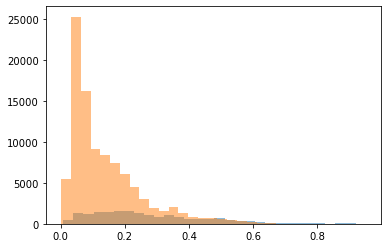

In [10]:
plt.hist(d[d['tobacco']==1]['post'], bins =30, alpha = 0.5)
plt.hist(d[d['tobacco']==0]['post'], bins = 30, alpha = 0.5)
plt.show()

In [171]:
#creating equal-sized bins
labels = [1] + [(i/10)+1 for i in range(10, 100, 10)]
d['bin'] = pd.qcut(d['post'], 10, labels=labels)

#print(d['bin'].describe())
#print(d['bin'].value_counts())

df = pd.get_dummies(d['bin'], prefix = 'bin')
#print(df.columns)

In [12]:
#creating bins of unequal size, but equal distances in propensity score
bin_sizes = [(0,.1)]
#creating bins
for i in range(1, 10, 1):
    #print(i)
    bin_sizes.append((i/10, (i+1)/10))
#print(bin_sizes)

#cutting dataset into bins
bins2 = pd.IntervalIndex.from_tuples(bin_sizes)
d['cat'] = pd.cut(d['post'], bins2)
#print(d['cat'])
#print(d['cat'].value_counts())

#indexing into dummies
df2 = pd.get_dummies(d['cat'], prefix = 'cat')
#print(df2.columns)

In [13]:
#testing balance in phat
for item in x1+x3:

    vals = sm.OLS(d[item], sm.add_constant(pd.concat([d['tobacco'],df2[['cat_(0.1, 0.2]', 'cat_(0.2, 0.3]', 'cat_(0.3, 0.4]',
       'cat_(0.4, 0.5]', 'cat_(0.5, 0.6]', 'cat_(0.6, 0.7]', 'cat_(0.7, 0.8]',
       'cat_(0.8, 0.9]', 'cat_(0.9, 1.0]']]], axis = 1)))
    out = vals.fit()
    print(item)
    print('coefficients')
    print(out.params[1:2])
    print('standard errors')
    print(out.bse[1:2])
    print('test stat')
    print(out.params[1:2]/out.bse[1:2])



alcohol
coefficients
tobacco   -0.000562
dtype: float64
standard errors
tobacco    0.000676
dtype: float64
test stat
tobacco   -0.832203
dtype: float64
mrace3_2
coefficients
tobacco   -0.004851
dtype: float64
standard errors
tobacco    0.001196
dtype: float64
test stat
tobacco   -4.056366
dtype: float64
mrace3_3
coefficients
tobacco   -0.002303
dtype: float64
standard errors
tobacco    0.002788
dtype: float64
test stat
tobacco   -0.825951
dtype: float64
ormothhis
coefficients
tobacco   -0.002634
dtype: float64
standard errors
tobacco    0.001603
dtype: float64
test stat
tobacco   -1.643124
dtype: float64
adeq_2.0
coefficients
tobacco    0.004483
dtype: float64
standard errors
tobacco    0.003481
dtype: float64
test stat
tobacco    1.287901
dtype: float64
adeq_3.0
coefficients
tobacco    0.000687
dtype: float64
standard errors
tobacco    0.001759
dtype: float64
test stat
tobacco    0.390506
dtype: float64
cardiac
coefficients
tobacco   -0.000102
dtype: float64
standard errors
tobacco   

In [14]:
#ATE
bins = ['cat_(0.0, 0.1]', 'cat_(0.1, 0.2]', 'cat_(0.2, 0.3]', 'cat_(0.3, 0.4]',
       'cat_(0.4, 0.5]', 'cat_(0.5, 0.6]', 'cat_(0.6, 0.7]', 'cat_(0.7, 0.8]',
       'cat_(0.8, 0.9]', 'cat_(0.9, 1.0]']
meandifs = []
totaldif = 0.0


for item in bins:
    d[item] = df2[item]
    d[item+'tobacco']= df2[item]*d['tobacco']
    #print(d[d[item+'tobacco']==1]['dbrwt'].mean())
    #print(d[d[item+'tobacco']+d[item]==1]['dbrwt'].mean())
    print('block')
    print(item[5:-1])
    print('mean difference in birthweight between smokers and nonsmokers within block')
    print(d[d[item+'tobacco']==1]['dbrwt'].mean() - d[d[item+'tobacco']+d[item]==1]['dbrwt'].mean())
    print('number of observations in block')
    print(d[item].sum())
    meandifs.append(d[d[item+'tobacco']==1]['dbrwt'].mean() - d[d[item+'tobacco']+d[item]==1]['dbrwt'].mean())
    totaldif = totaldif + (d[d[item+'tobacco']==1]['dbrwt'].mean() - d[d[item+'tobacco']+d[item]==1]['dbrwt'].mean())*d[item].sum()
    
print(meandifs)
print('ATE')
print(totaldif/d.shape[:1])


block
0.0, 0.1
mean difference in birthweight between smokers and nonsmokers within block
-214.03892322082083
number of observations in block
51636
block
0.1, 0.2
mean difference in birthweight between smokers and nonsmokers within block
-217.51571334050413
number of observations in block
30831
block
0.2, 0.3
mean difference in birthweight between smokers and nonsmokers within block
-213.88813757182743
number of observations in block
15990
block
0.3, 0.4
mean difference in birthweight between smokers and nonsmokers within block
-187.36128847081727
number of observations in block
8112
block
0.4, 0.5
mean difference in birthweight between smokers and nonsmokers within block
-157.58378092833573
number of observations in block
4272
block
0.5, 0.6
mean difference in birthweight between smokers and nonsmokers within block
-197.5916129653915
number of observations in block
2614
block
0.6, 0.7
mean difference in birthweight between smokers and nonsmokers within block
-284.9227038183694
number 

In [15]:
#ATT
bins = ['cat_(0.0, 0.1]', 'cat_(0.1, 0.2]', 'cat_(0.2, 0.3]', 'cat_(0.3, 0.4]',
       'cat_(0.4, 0.5]', 'cat_(0.5, 0.6]', 'cat_(0.6, 0.7]', 'cat_(0.7, 0.8]',
       'cat_(0.8, 0.9]', 'cat_(0.9, 1.0]']
meandifs = []
totaldif = 0.0


for item in bins:
    d[item] = df2[item]
    d[item+'tobacco']= df2[item]*d['tobacco']
    #print(d[d[item+'tobacco']==1]['dbrwt'].mean())
    #print(d[d[item+'tobacco']+d[item]==1]['dbrwt'].mean())
    print('block')
    print(item[5:-1])
    print('mean difference in birthweight between smokers and nonsmokers within block')
    print(d[d[item+'tobacco']==1]['dbrwt'].mean() - d[d[item+'tobacco']+d[item]==1]['dbrwt'].mean())
    print('number of smokers in block')
    print(d[item+'tobacco'].sum())
    meandifs.append(d[d[item+'tobacco']==1]['dbrwt'].mean() - d[d[item+'tobacco']+d[item]==1]['dbrwt'].mean())
    totaldif = totaldif + (d[d[item+'tobacco']==1]['dbrwt'].mean() - d[d[item+'tobacco']+d[item]==1]['dbrwt'].mean())*d[item+'tobacco'].sum()
    
print(meandifs)
print('ATT')
print(totaldif/d['tobacco'].sum())


block
0.0, 0.1
mean difference in birthweight between smokers and nonsmokers within block
-214.03892322082083
number of smokers in block
2754.0
block
0.1, 0.2
mean difference in birthweight between smokers and nonsmokers within block
-217.51571334050413
number of smokers in block
4650.0
block
0.2, 0.3
mean difference in birthweight between smokers and nonsmokers within block
-213.88813757182743
number of smokers in block
3987.0
block
0.3, 0.4
mean difference in birthweight between smokers and nonsmokers within block
-187.36128847081727
number of smokers in block
2763.0
block
0.4, 0.5
mean difference in birthweight between smokers and nonsmokers within block
-157.58378092833573
number of smokers in block
1897.0
block
0.5, 0.6
mean difference in birthweight between smokers and nonsmokers within block
-197.5916129653915
number of smokers in block
1386.0
block
0.6, 0.7
mean difference in birthweight between smokers and nonsmokers within block
-284.9227038183694
number of smokers in block
4

In [16]:
#4e

#Di/p(Xi)
d['wt'] = d['tobacco'] / d['post']

#(1-Di)/(1-p(Xi))
d['wt2'] = (1 - d['tobacco']) /(1 -  d['post'])

#YiDi/p(Xi)
d['plugin'] = d['dbrwt']*d['wt']

#Yi(1-Di)/(1-p(Xi))
d['plugin2'] = d['dbrwt']*d['wt2']

#adding, dividing, and subtracting to get "improved performance" ATE
print('reweighted ATE')
ATE = (d['plugin'].sum()/d['wt'].sum()) - (d['plugin2'].sum()/d['wt2'].sum())
print(ATE)

reweighted ATE
-213.16820976094368


In [17]:
d['D'] = d['tobacco']

d['X'] = ((d['tobacco'] - d['post'])*d['dbrwt'])/(1 -  d['post'])

ATT = d['X'].sum()/d['D'].sum()
print('ATT- Wooldridge')
print(ATT)

ATT- Wooldridge
-199.8735150613276
